In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import statsmodels.stats.multitest as multi

In [2]:
from regression import fit_plot_validate, dict_results

## Settings

In [3]:
#x_size, y_size = 12,8
plt.rcParams.update({'font.size': 14})

# Read the data
### Main data

In [4]:
df = pd.read_csv("data\\pace_counters.csv", encoding="utf8")

### Counters per route

In [5]:
f = open("data\\counters_per_route.txt", encoding="utf8")
route_counters = {}

for l in f:
    ss = l.strip().split(";")
    route_id = ss[0] 
    route_id = int(route_id)
    cs = ss[1:]    
    if cs != ['']:
        route_counters[route_id] = cs
        
route_counters    

{0: ['1016-140', '1034-216-1', '1038-276', '1025-116'],
 1: ['1016-140', '1947-211', '1946-230-1'],
 2: ['1935-230', '1035-136'],
 3: ['1014-150'],
 4: ['1001-156', '1021-156'],
 5: ['0174-1', '0855-1', '1010-1']}

# Automatic

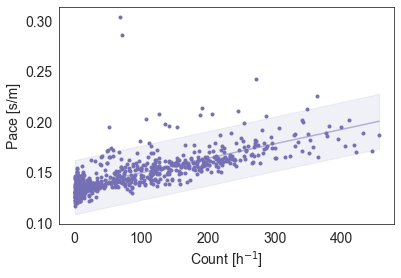

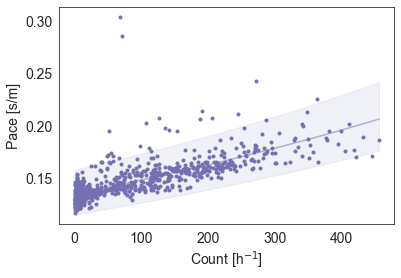

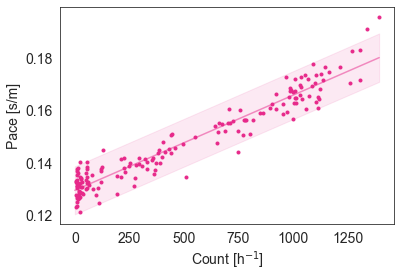

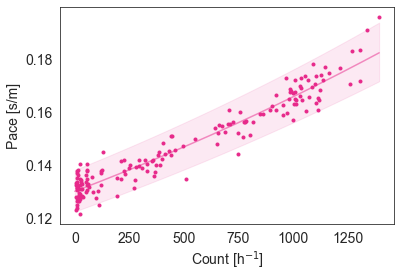

In [6]:
df_results = pd.DataFrame(columns=dict_results())

plot_on = True
k = 10

for route_id in route_counters:
    df2 = df[df["route_id"]==route_id].copy()

    counters = route_counters[route_id]

    df2 = df2[['pace'] + counters] 
    df2 = df2.dropna(axis='columns', how="all")
    df2 = df2.dropna(axis="rows")

    counters = list(df2.columns[1:])
    
    if counters:
        
        X = df2[counters].values
        
        # generate samples for k-fold cross validation test sets
        n = X.shape[0]
        idxs_all = np.arange(n)
        np.random.shuffle(idxs_all)
        idxs_all = idxs_all[:k*(n//k)]
        idxs_tests = idxs_all.reshape(k, n//k)
        
        counters_display = ["conts"] + counters

        
        # linear
        model_type = "lin"
        Y = df2['pace'].values
        results, R2_cross = fit_plot_validate(X,Y,idxs_tests, route_id=route_id, plot_on = plot_on)#, training_size = training_size, repeats = repeats)
      
        dict_res = dict_results(route_id, counters_display, model_type, results, R2_cross)
        df_results = df_results.append(dict_res, ignore_index=True)

        # exponential
        model_type = "exp"
        Y = np.log(df2['pace'].values) 
        results, R2_cross = fit_plot_validate(X,Y,idxs_tests, route_id =route_id, trans=model_type, plot_on = plot_on)#, training_size = training_size, repeats = repeats)

        dict_res = dict_results(route_id, counters_display, model_type, results, R2_cross)
        df_results = df_results.append(dict_res, ignore_index=True)

        # logarithmic
        #model_type = "log"
        #Y = np.e**df2['pace'].values
        #results, R2_cross = fit_plot_validate(X,Y,idxs_tests, route_id=route_id, trans=model_type, plot_on = plot_on)#, training_size = training_size, repeats = repeats)

        #dict_res = dict_results(route_id, counters_display, model_type, results, R2_cross)
        #df_results = df_results.append(dict_res, ignore_index=True)

    

In [8]:
df_results.to_csv("regression_results\\regression.csv", encoding="utf-8", index=False)

In [10]:
df_results["q"] = multi.multipletests(df_results["p"], method = 'fdr_bh')[1]


df_results_brief = df_results[["route_id", "model_type", "p", "q", "R2", "R2_test_mean", "R2_test_std"]].copy()
df_results_brief.columns = ["route ID", "model type", "p", "q", "R2", "mu_R2", "sigma_R2"]
df_results_brief[df_results_brief.columns[2:4]] = df_results_brief[df_results_brief.columns[2:4]].applymap(lambda x: round(x,2))
df_results_brief[df_results_brief.columns[4:]] = df_results_brief[df_results_brief.columns[4:]].applymap(lambda x: round(x,4))

df_results_brief.loc[df_results_brief["model type"] == "lin", "model type"] = "linear"
df_results_brief.loc[df_results_brief["model type"] == "exp", "model type"] = "exponential"

In [11]:
df_results_brief.to_csv("regression_results\\regression_brief.csv", encoding="utf-8", index=False, sep="\t")